In [107]:
from deep_mri.train.config_parser import config_to_ds, config_to_model, config_to_callbacks, config_batch_size, config_epochs

In [115]:
import tensorflow  as tf
print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [116]:
import json
with open('/home/karelto1/master_thesis/configs/karasawa.json', 'r') as f:
    config = json.load(f)


In [119]:
import glob
import pandas as pd
import random
from deep_mri.dataset.dataset import _get_image_group, _get_image_id, CLASS_NAMES
import deep_mri.dataset

files_list = glob.glob(config['dataset_path'])
# meta info
df = pd.read_csv(config['data_csv_path'])
df = df.set_index('Image Data ID')
df['Group'] = df['Group'].str.lower()
meta_info = df[['Visit', 'Group', 'Subject']].to_dict('index')
subjects = {c: [] for c in CLASS_NAMES}
for f in files_list:
    image_id = _get_image_id(f)
    target = _get_image_group(f, -3)
    assert target == meta_info[image_id]['Group']
    subject = meta_info[image_id]['Subject']
    visit = meta_info[image_id]['Visit']
    if visit == 1:
        subjects[target].append(subject)
    # Shuffle
    rnd = random.Random(42)
    for group in groups:
        rnd.shuffle(group)

from sklearn.model_selection import KFold
import numpy as np
def cross_validation_files(subjects): 
    ad = np.array(subjects['ad'])
    mci = np.array(subjects['mci'])
    cn = np.array(subjects['cn'])
    kf = KFold(n_splits=5)

    for ad_idx, mci_idx, cn_idx in zip(kf.split(ad), kf.split(mci), kf.split(cn)):
        ad_train, ad_valid = ad[ad_idx[0]], ad[ad_idx[1]]
        mci_train, mci_valid = mci[mci_idx[0]], mci[mci_idx[1]]
        cn_train, cn_valid = cn[cn_idx[0]], cn[cn_idx[1]]

        train_subjects = set(np.concatenate([ad_train, mci_train, cn_train]))
        valid_subjects = set(np.concatenate([ad_valid, mci_valid, cn_valid]))

        train_files, valid_files = [], []
        train_targets, valid_targets =  [], []
        for f in files_list:
            image_id = int(_get_image_id(f))
            subject = meta_info[image_id]['Subject']
            target = _get_image_group(f, -3)
            assert target == meta_info[image_id]['Group']
            if subject in train_subjects: 
                train_files.append(f)
                train_targets.append(target)
            elif subject in valid_subjects: 
                valid_files.append(f)
                valid_targets.append(target)
            else: 
                pass
                #print(f'No first visit {subject}')
        yield train_files, train_targets,  valid_files, valid_targets
        
from deep_mri.dataset import dataset_3d
histories = []
for train_files, train_targets, valid_files, valid_targets in cross_validation_files(subjects):
    train_ds, valid_ds = dataset_3d.factory(train_files, train_targets, valid_files, valid_targets, CLASS_NAMES, **config['dataset_args'])
    print(train_ds, valid_ds)
    batch_size = config_batch_size(config)
    model = config_to_model(config)
    epochs = 20 

    history = model.fit(train_ds.batch(batch_size),
              epochs=epochs,
              validation_data=valid_ds.batch(batch_size),
              verbose=1,
              workers=40,
              use_multiprocessing=True)
    
    histories.append(history)
    
    
json_dict = {}
for i, hist in enumerate(histories): 
    json_dict[i] = hist.history
print(json_dict)
with open("history.json", "w") as f: 
    json.dump(json_dict, f)

<PrefetchDataset shapes: ((96, 96, 64, 1), (3,)), types: (tf.float32, tf.bool)> <PrefetchDataset shapes: ((96, 96, 64, 1), (3,)), types: (tf.float32, tf.bool)>
Epoch 1/20
867/867 [==============================] - 776s 895ms/step - loss: 1.0549 - accuracy: 0.4876 - auc: 0.6323 - val_loss: 1.0413 - val_accuracy: 0.5094 - val_auc: 0.6368
Epoch 2/20
867/867 [==============================] - 777s 897ms/step - loss: 1.0472 - accuracy: 0.4893 - auc: 0.6363 - val_loss: 1.0409 - val_accuracy: 0.5094 - val_auc: 0.6375
Epoch 3/20
867/867 [==============================] - 778s 898ms/step - loss: 1.0421 - accuracy: 0.4893 - auc: 0.6386 - val_loss: 1.0434 - val_accuracy: 0.5094 - val_auc: 0.6472
Epoch 4/20
867/867 [==============================] - 779s 898ms/step - loss: 1.0467 - accuracy: 0.4893 - auc: 0.6342 - val_loss: 1.0343 - val_accuracy: 0.5094 - val_auc: 0.6401
Epoch 5/20
867/867 [==============================] - 778s 897ms/step - loss: 1.0391 - accuracy: 0.4893 - auc: 0.6478 - val_loss

{0: {'loss': [1.0608654022216797], 'accuracy': [0.4881708025932312], 'auc': [0.6279915571212769], 'val_loss': [1.042761206626892], 'val_accuracy': [0.5094339847564697], 'val_auc': [0.6377358436584473]}, 1: {'loss': [1.0600383281707764], 'accuracy': [0.4843657910823822], 'auc': [0.6226066946983337], 'val_loss': [1.0199543237686157], 'val_accuracy': [0.5148515105247498], 'val_auc': [0.6459987759590149]}, 2: {'loss': [1.1051051616668701], 'accuracy': [0.48927536606788635], 'auc': [0.6395657062530518], 'val_loss': [1.0606931447982788], 'val_accuracy': [0.4761904776096344], 'val_auc': [0.6027888655662537]}}


In [133]:
json_dict

{0: {'loss': [1.0608654022216797],
  'accuracy': [0.4881708025932312],
  'auc': [0.6279915571212769],
  'val_loss': [1.042761206626892],
  'val_accuracy': [0.5094339847564697],
  'val_auc': [0.6377358436584473]},
 1: {'loss': [1.0600383281707764],
  'accuracy': [0.4843657910823822],
  'auc': [0.6226066946983337],
  'val_loss': [1.0199543237686157],
  'val_accuracy': [0.5148515105247498],
  'val_auc': [0.6459987759590149]},
 2: {'loss': [1.1051051616668701],
  'accuracy': [0.48927536606788635],
  'auc': [0.6395657062530518],
  'val_loss': [1.0606931447982788],
  'val_accuracy': [0.4761904776096344],
  'val_auc': [0.6027888655662537]}}

In [90]:
assert "optimizer" in config
optimizer = config["optimizer"]
assert "loss" in config
loss = config["loss"]
assert "metrics" in config
assert ('model' in config) and ('model_args' in config)
model_name = config['model']
model_args = config['model_args']

metrics = config['metrics']

input_layer =  tf.keras.Input([192, 228, 192, 1])
outputs = []
for i in range(8):
    layer = tf.keras.layers.Conv3D(1,3,1,'same', activation='relu')(input_layer)
    layer = tf.keras.layers.MaxPool3D(2,2,)(layer)
    layer = tf.keras.layers.Conv3DTranspose(1,3,2,'same',activation='relu')(layer)
    outputs.append(layer)

sum_layer = tf.keras.layers.Add()(outputs)
model = tf.keras.Model(inputs=input_layer, outputs=sum_layer)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

model.fit(train_ds.batch(batch_size),
          epochs=epochs,
          validation_data=valid_ds.batch(batch_size),
          callbacks=callbacks,
          use_multiprocessing=True,
          workers=40)

NameError: name 'batch_size' is not defined

In [127]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.summary(line_length=130)

Model: "model_7"
__________________________________________________________________________________________________________________________________
Layer (type)                              Output Shape                 Param #         Connected to                               
input_10 (InputLayer)                     [(None, 192, 228, 192, 1)]   0                                                          
__________________________________________________________________________________________________________________________________
conv3d_8 (Conv3D)                         (None, 192, 228, 192, 1)     28              input_10[0][0]                             
__________________________________________________________________________________________________________________________________
conv3d_9 (Conv3D)                         (None, 192, 228, 192, 1)     28              input_10[0][0]                             
__________________________________________________________________

In [128]:
model.fit(train_ds.batch(batch_size),
          epochs=epochs,
          validation_data=valid_ds.batch(batch_size),
          callbacks=callbacks,
          use_multiprocessing=True,
          workers=40)

     68/Unknown - 490s 7s/step - loss: 0.4918 - mse: 0.4918

KeyboardInterrupt: 

In [112]:
new_layers = []
new_weights = []
for l in model.layers[:17]:
    config = l.get_config()
    weights = l.get_weights()
    if config['name'].startswith('conv3d'):
        new_layers.append(tf.keras.layers.Conv3D.from_config(config))
        new_weights.append(weights)

In [113]:
new_layers[0].set_weights

<bound method Layer.set_weights of <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x7efbc049fa00>>

In [124]:
input_layer =  tf.keras.Input([192, 228, 192, 1])
outputs = []
for i in range(8):
    layer = new_layers[i](input_layer)
    layer = tf.keras.layers.MaxPool3D(2,2,)(layer)
    layer = tf.keras.layers.Conv3D(1,3,1,'same', activation='relu')(layer)
    layer = tf.keras.layers.MaxPool3D(2,2,)(layer)
    layer = tf.keras.layers.Conv3DTranspose(1,3,2,'same',activation='relu')(layer)
    layer = tf.keras.layers.Conv3DTranspose(1,3,2,'same',activation='relu')(layer)
    outputs.append(layer)
output_layer = tf.keras.layers.Add()(outputs)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [125]:
for i,l in enumerate(model.layers[1:9]):
    l.set_weights(new_weights[i])

In [31]:
Hosseini_encoder = tf.keras.Sequential([
    tf.keras.layers.Conv3D(8,3,1,'same', activation='relu'),
    tf.keras.layers.MaxPool3D(2,2,),
    tf.keras.layers.Conv3D(8,3,1,'valid', activation='relu'),
    tf.keras.layers.MaxPool3D(2,2),
    tf.keras.layers.Conv3D(8,3,1,'valid', activation='relu'),
    tf.keras.layers.MaxPool3D(2,2),
    tf.keras.layers.Flatten()
])
Hosseini_classificator = tf.keras.Sequential([
    tf.keras.layers.Dense(2000, 'relu'), 
    tf.keras.layers.Dense(500, 'relu'),
    tf.keras.layers.Dense(3, 'softmax')
])
model = tf.keras.Sequential([
tf.keras.Input([193, 229, 193, 1]),
Hosseini_encoder, 
Hosseini_classificator,
])

assert "optimizer" in config
optimizer = config["optimizer"]
assert "loss" in config
loss = config["loss"]
assert "metrics" in config
assert ('model' in config) and ('model_args' in config)
model_name = config['model']
model_args = config['model_args']

metrics = config['metrics']



In [104]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [105]:
train_ds, valid_ds = dataset_factory(dataset_name='encoder',
                                     train_filter_first_screen=False,
                                     valid_filter_first_screen=False, 
                                     dropping_group=None,
                                     shuffle_strategy='random'
                                    )

NameError: name 'dataset_factory' is not defined

In [ ]:
from nilearn.image import resample_img, crop_img
from nilearn.plotting import plot_anat


In [ ]:
model 

In [ ]:
img = nib.load('/home/karelto1/MRI/minc_core/ad/_image_id_102387/ADNI_041_S_1368_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080414091434750_S47373_I102387_normalized.nii')

In [ ]:
plot_anat(img)

In [ ]:
import numpy as np
ratio = 2.479
np.ceil(np.array(img.shape) / ratio)

In [ ]:
img2 = resample_img(img, target_affine=np.eye(3) / ratio)

In [ ]:
plot_anat(img2)

In [ ]:
img2.shape

In [ ]:
fsl.utils.image.resample.resampleToPixdims(image, newPixdims, **kwargs)

In [ ]:
import fslpy

In [ ]:
!pip install fslpy

In [ ]:
class HosseiniEncodingBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, paralel_conv=8):
        super(HosseiniEncodingBlock, self).__init__(name='')
        conv_filters = []
        max_pools
        for i in range(paralel_conv):
            layer = tf.keras.layers.Conv3D(1,3,1,'same', activation='relu')(input_layer)
            layer = tf.keras.layers.MaxPool3D(2,2,)(layer)
            
    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

In [19]:
cnn_model.output.shape

TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got (None, 96, 114, 96, 1).

In [175]:
for o in first_layer.output:
    print(o)


Tensor("max_pooling3d_320/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_321/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_322/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_323/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_324/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_325/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_326/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)
Tensor("max_pooling3d_327/Identity:0", shape=(None, 96, 114, 96, 1), dtype=float32)


In [ ]:
[33,33,33]

In [ ]:
nimg, _ = resample.res(myimg, (79, 93, 79))

In [ ]:
from deep_mri.dataset.dataset import numpy_to_nibabel
from nilearn.plotting import plot_anat

plot_anat(numpy_to_nibabel(img.numpy()))

In [ ]:
path = '/home/karelto1/MRI/minc_core/ad/_image_id_102387/ADNI_041_S_1368_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080414091434750_S47373_I102387_normalized.nii'

In [ ]:
%timeit 100
from fsl.data.image import Image
myimg = Image('/home/karelto1/MRI/minc_core/ad/_image_id_102387/ADNI_041_S_1368_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080414091434750_S47373_I102387_normalized.nii')
nimg, _ = resample.resample(myimg, (79, 93, 79))
nimg.data

In [ ]:
%timeit 100
img = nib.load(path)
img = resample_img(img, target_affine=np.eye(3) * 2.5)
img.get_fdata()

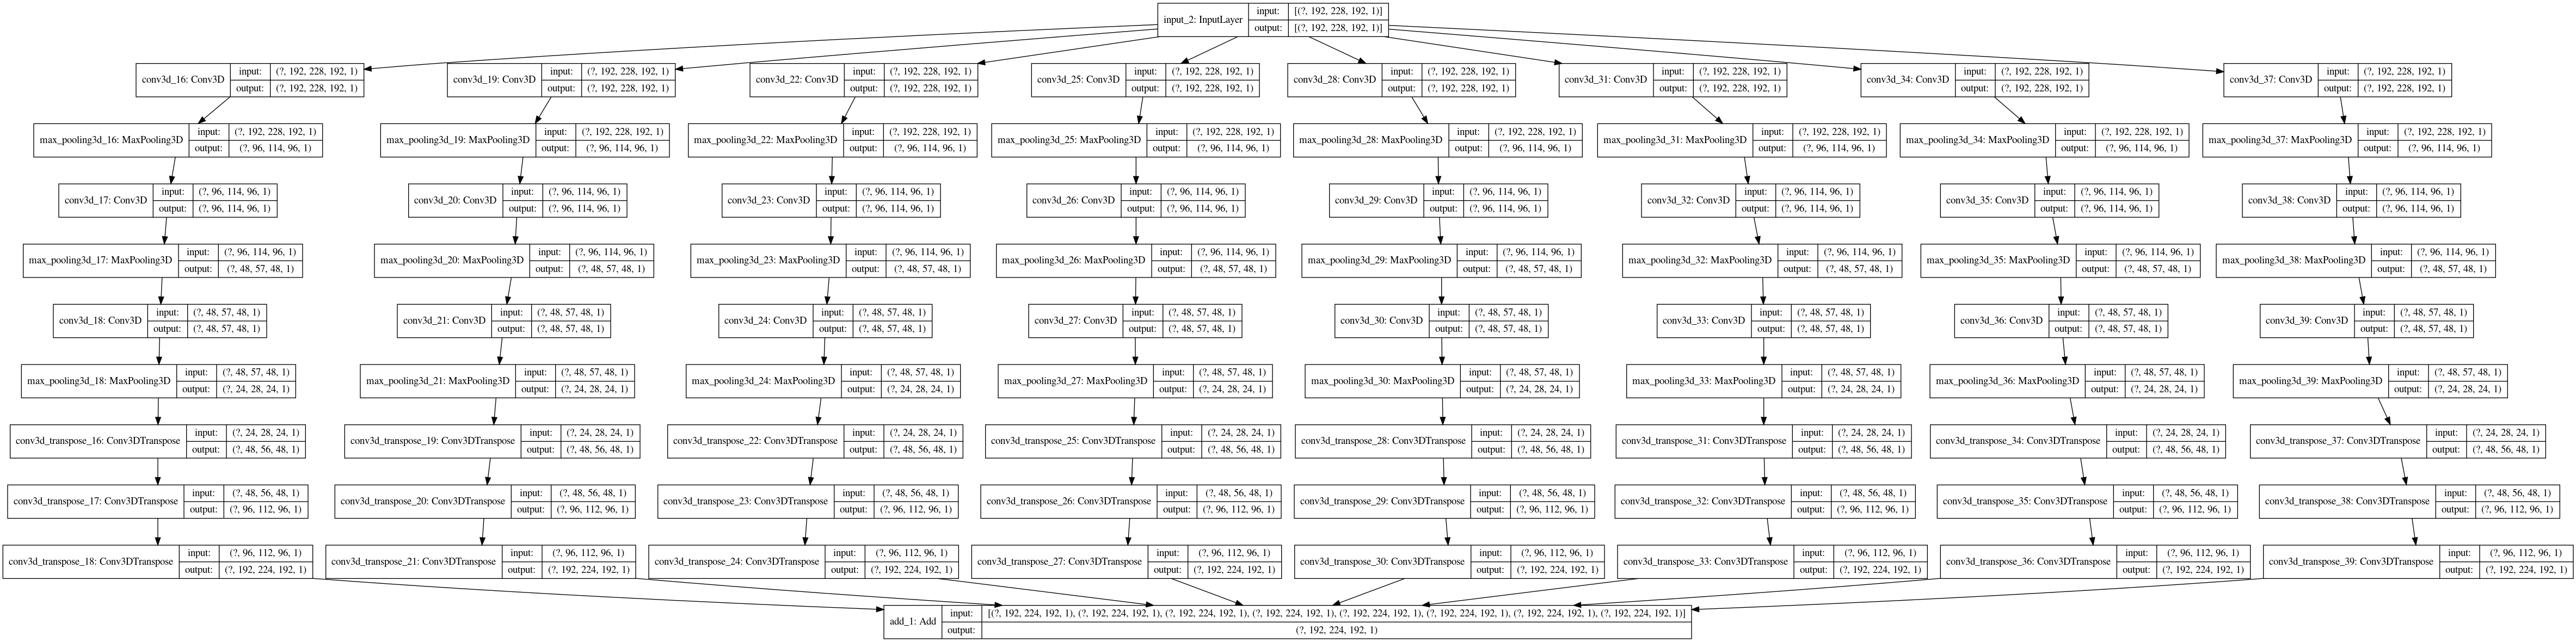

In [6]:


model = hossein_encoder_3(tf.keras.layers.Input([192, 228, 192, 1]))
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [7]:
def first_encoder_hosseni(input_layer):
    

def inner_encoder_hosseni(inputs):
    outputs = []
    for in_layer in inputs: 
        layer = tf.keras.layers.Conv3D(1,3,1, 'same', activation='relu')(in_layer)
        layer = tf.keras.layers.MaxPool3D(2,2,)(layer)
        outputs.append(layer)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def transposed_conv_hosseni(inputs): 
    outputs = []
    for in_layer in inputs:
        layer = tf.keras.layers.Conv3DTranspose(1,3,2,'same',activation='relu')(layer)
        outputs.append(outputs)
    return outputs
    

IndentationError: expected an indented block (<ipython-input-7-1210271f4872>, line 4)

In [19]:
class ResnetBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, enlarge=False, strides=1):
        super(ResnetBlock, self).__init__(name='')

        self.conva = tf.keras.layers.Conv3D(filters, kernel_size, activation='relu', padding='same')
        self.convb = tf.keras.layers.Conv3D(filters, kernel_size,  strides=strides, activation=None, padding='same')
        if enlarge:
            self.conv = tf.keras.layers.Conv3D(filters, 1, strides=strides, activation=None, padding='same')
        else:
            self.conv = None
        self.acti = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()


    def call(self, input_tensor, training=False):
        x = self.conva(input_tensor)
        x = self.convb(x)
        
        if self.conv is not None:
            input_tensor = self.conv(input_tensor)
        x = self.add([x, input_tensor])
        x = self.acti(x)
                     
        return x


In [28]:
tf.keras.Sequential([ 
    tf.keras.layers.Input([96, 96, 64, 1]), 
    tf.keras.layers.Conv3D(16, 5, strides=2, activation='relu', padding='same'),
    ResnetBlock(3,16),
    ResnetBlock(3,16),
    ResnetBlock(3,32, enlarge=True, strides=2),
    ResnetBlock(3,32),
    ResnetBlock(3,32),
    ResnetBlock(3,32),
    ResnetBlock(3,64, enlarge=True, strides=2),
    ResnetBlock(3,64),
    ResnetBlock(3,64),
    ResnetBlock(3,64),
    ResnetBlock(3,64),
    ResnetBlock(3,64),
    ResnetBlock(3,128, enlarge=True, strides=2),
    ResnetBlock(3,128),
    ResnetBlock(3,128),
    ResnetBlock(3,128),
    ResnetBlock(3,128, enlarge=True, strides=2),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.AveragePooling3D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_192 (Conv3D)          (None, 48, 48, 32, 16)    2016      
_________________________________________________________________
resnet_block_79 (ResnetBlock (None, 48, 48, 32, 16)    13856     
_________________________________________________________________
resnet_block_80 (ResnetBlock (None, 48, 48, 32, 16)    13856     
_________________________________________________________________
resnet_block_81 (ResnetBlock (None, 24, 24, 16, 32)    42080     
_________________________________________________________________
resnet_block_82 (ResnetBlock (None, 24, 24, 16, 32)    55360     
_________________________________________________________________
resnet_block_83 (ResnetBlock (None, 24, 24, 16, 32)    55360     
_________________________________________________________________
resnet_block_84 (ResnetBlock (None, 24, 24, 16, 32)  

In [21]:
input_l = 
input_l = 
conv2a = tf.keras.layers.Conv3D(16, 3, activation='relu', padding='same')(input_l)
conv2b = tf.keras.layers.Conv3D(16, 3, activation='relu', padding='same')(conv2a)
add = tf.keras.layers.Add()([conv2b, input_l])
acti = tf.keras.layers.Activation('relu')(add)

SyntaxError: invalid syntax (<ipython-input-21-bb0f27921d04>, line 1)

In [45]:
class Residual(tf.keras.Model):  #@save
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [46]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [53]:
model = tf.keras.Sequential([
        tf.keras.layers.Input([256, 256, 1]),
        # The following layers are the same as b1 that we created earlier.
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

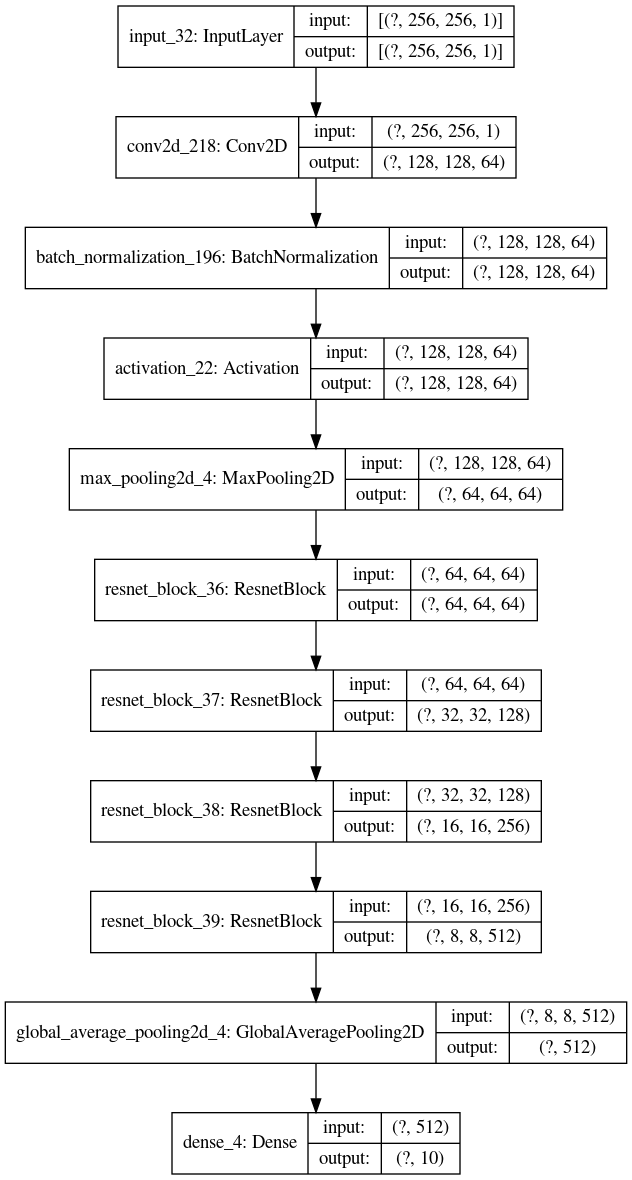

In [55]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
from